In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from IPython import display

In [43]:
pip show tensorflow

Name: tensorflow
Version: 2.16.2
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /Users/petter/skole/master/courses/DAT255/project/venv/lib/python3.9/site-packages
Requires: packaging, tensorflow-io-gcs-filesystem, typing-extensions, opt-einsum, tensorboard, protobuf, google-pasta, six, requests, grpcio, termcolor, flatbuffers, libclang, keras, numpy, wrapt, h5py, astunparse, ml-dtypes, gast, absl-py, setuptools
Required-by: tensorflow-macos
Note: you may need to restart the kernel to use updated packages.


In [7]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [9]:
data_dir = "data/mini_speech_commands_extracted/mini_speech_commands"

In [10]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['right' 'go' 'no' 'left' 'stop' 'up' 'down' 'yes']


In [11]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both'
)

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.


2025-03-17 14:37:37.315947: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-03-17 14:37:37.315995: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-17 14:37:37.316008: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-17 14:37:37.316035: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-17 14:37:37.316057: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)



label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [12]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [13]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [14]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [15]:
for example_audio, example_labels in train_ds.take(1):
    print(example_audio.shape)
    print(example_labels.shape)

(64, 16000)
(64,)


2025-03-17 14:41:27.730887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [16]:
label_names[[1, 1, 3, 0]]

array(['go', 'go', 'no', 'down'], dtype='<U5')

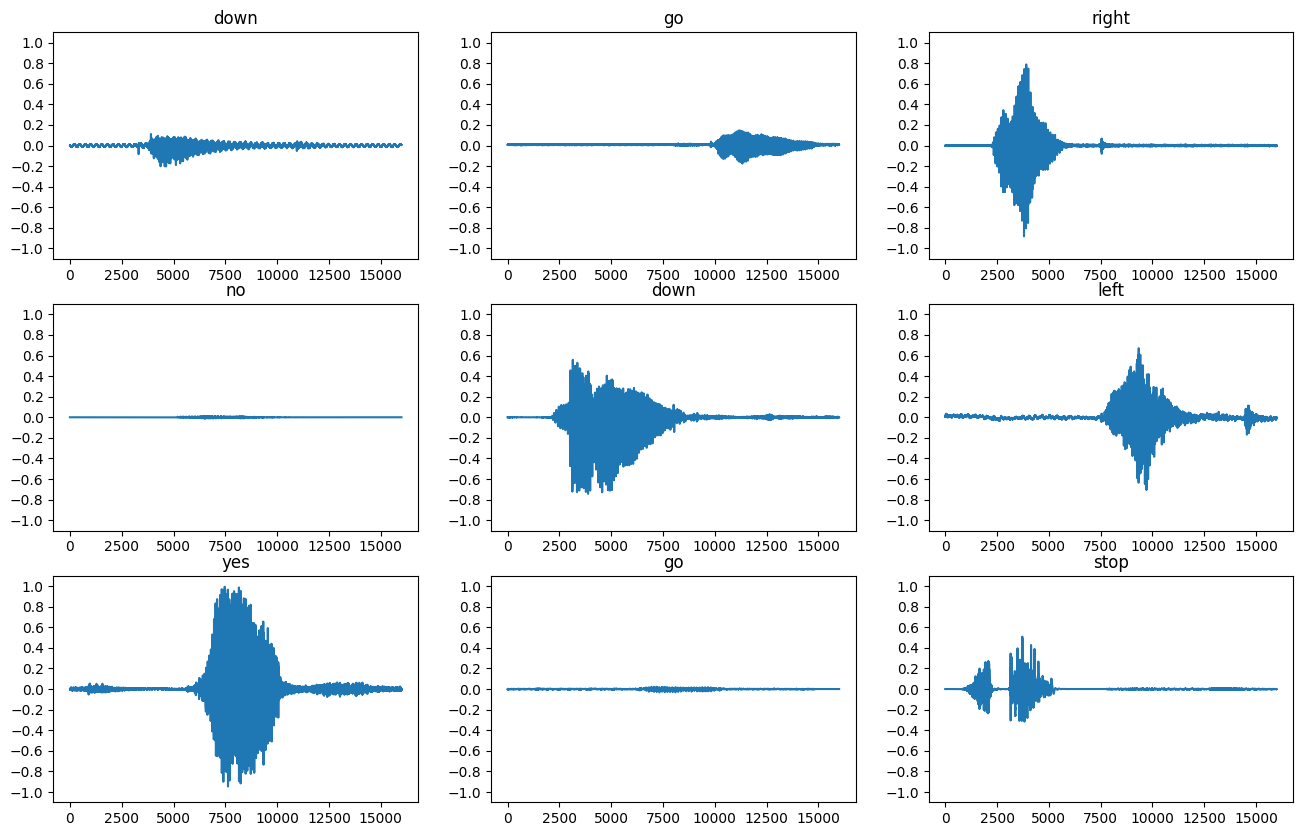

In [17]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

In [18]:
def get_spectogram(waveform):
    spectogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128
    )
    spectogram = tf.abs(spectogram)
    spectogram = spectogram[..., tf.newaxis]
    return spectogram

In [19]:
for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectogram = get_spectogram(waveform)

    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectogram shape:', spectogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

Label: down
Waveform shape: (16000,)
Spectogram shape: (124, 129, 1)
Audio playback


Label: go
Waveform shape: (16000,)
Spectogram shape: (124, 129, 1)
Audio playback


Label: right
Waveform shape: (16000,)
Spectogram shape: (124, 129, 1)
Audio playback


In [20]:
def plot_spectogram(spectogram, ax):
    if len(spectogram.shape) > 2:
        assert len(spectogram.shape) == 3
        spectogram = np.squeeze(spectogram, axis=-1)

        log_spec = np.log(spectogram.T + np.finfo(float).eps)
        height = log_spec.shape[0]
        width = log_spec.shape[1]
        X = np.linspace(0, np.size(spectogram), num=width, dtype=int)
        Y = range(height)
        ax.pcolormesh(X, Y, log_spec)

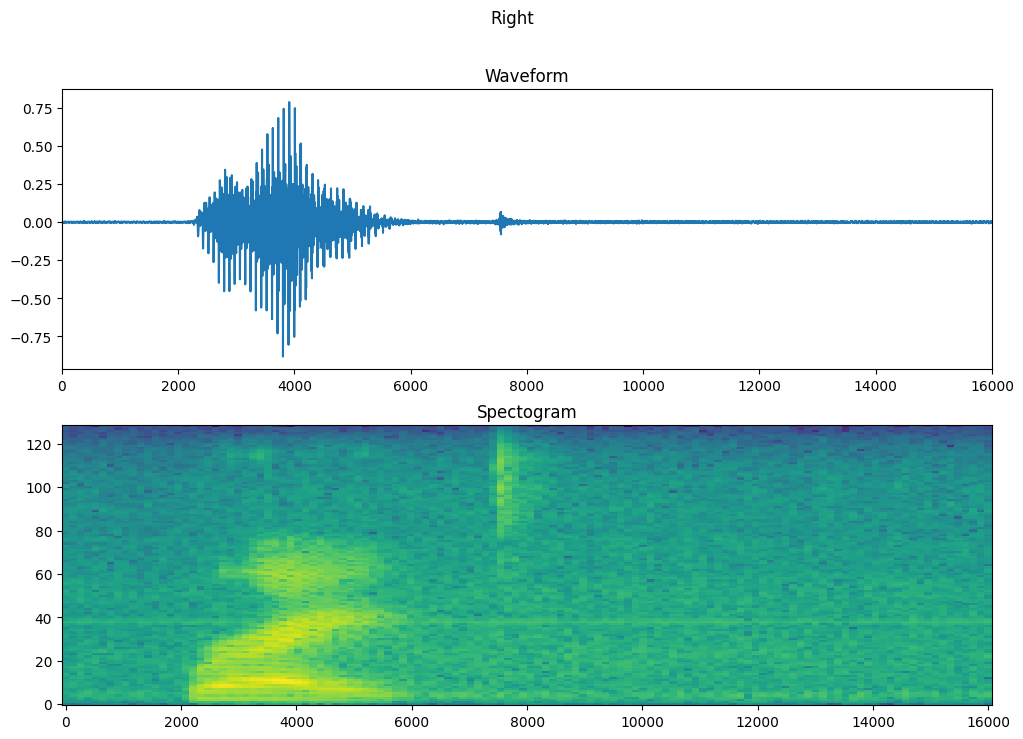

In [22]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectogram(spectogram.numpy(), axes[1])
axes[1].set_title('Spectogram')
plt.suptitle(label.title())
plt.show()

In [23]:
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_spectogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

In [24]:
train_spectogram_ds = make_spec_ds(train_ds)
val_spectogram_ds = make_spec_ds(val_ds)
test_spectogram_ds = make_spec_ds(test_ds)

In [25]:
for example_spectograms, example_spect_labels in train_spectogram_ds.take(1):
    break

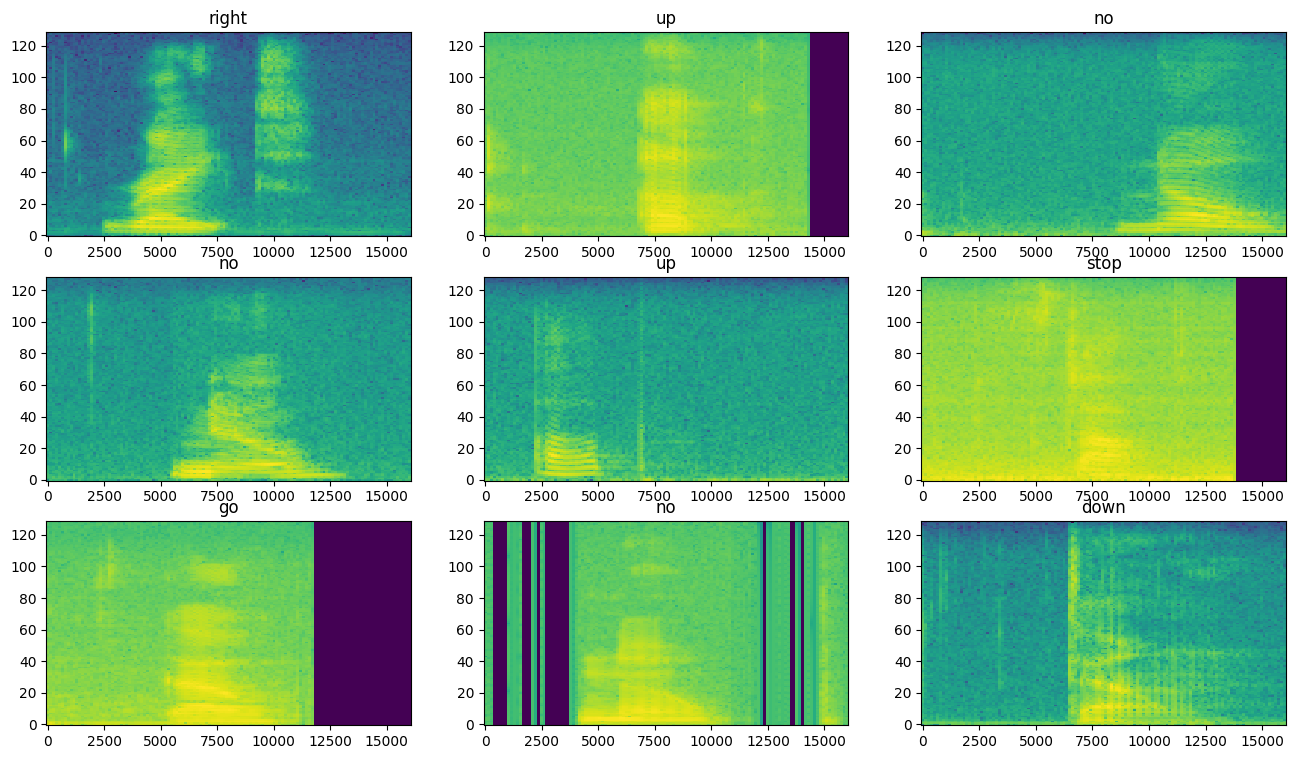

In [27]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectogram(example_spectograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [29]:
train_spectogram_ds = train_spectogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectogram_ds = val_spectogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectogram_ds = test_spectogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [31]:
input_shape = example_spectograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)


2025-03-17 15:14:11.112532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_1 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,611 (6.20 MB)

 Trainable params: 1,625,608 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

In [33]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [40]:
EPOCHS = 10

history = model.fit(
    train_spectogram_ds,
    validation_data=val_spectogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6089 - loss: 2.6004 - val_accuracy: 0.7044 - val_loss: 1.4801
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6076 - loss: 2.9170 - val_accuracy: 0.7018 - val_loss: 1.4634
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6129 - loss: 2.5552 - val_accuracy: 0.7396 - val_loss: 1.4650
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6136 - loss: 2.8140 - val_accuracy: 0.6888 - val_loss: 1.9281
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6183 - loss: 2.8070 - val_accuracy: 0.7396 - val_loss: 1.3664
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6261 - loss: 2.8878 - val_accuracy: 0.6445 - val_loss: 2.2209
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6104 - loss: 3.1501 - val_accuracy: 0.7005 - val_loss: 1.6844
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6166 - loss: 3.1606 - val_accu

Text(0, 0.5, 'Accuracy [%]')

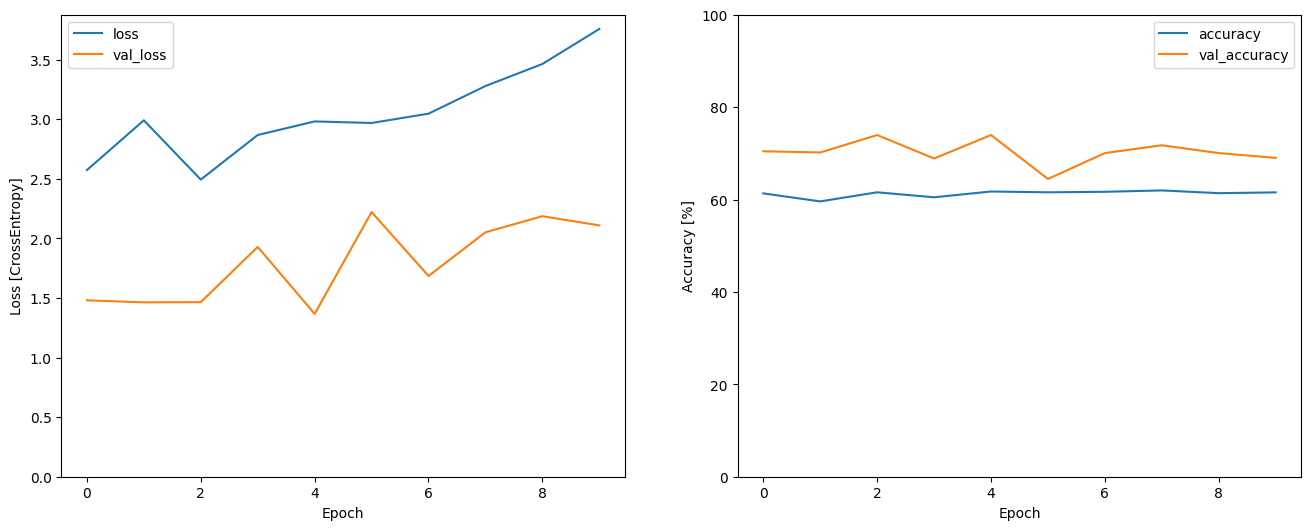

In [41]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [42]:
model.evaluate(test_spectogram_ds, return_dict=True)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6942 - loss: 2.5253


{'accuracy': 0.707932710647583, 'loss': 2.5664563179016113}